### Importar bibliotecas

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse

### Carregar dados

In [2]:
# Carregar dados do CPU
workload = pd.read_csv('m_3330.csv', 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


### Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dados de CPU
test_len = len(workload)//3
train_set = workload.cpu[:-test_len+90]
test_set = workload.cpu[-test_len:]

### Rede Neural

In [4]:
# Implementação e salvamento da rede neural
reshaped_train_set = np.reshape(workload.cpu[:-test_len].values, (-1, 1)) # carrega os dados de CPU em 2D
normalizer = MinMaxScaler(feature_range = (0,1)) # normaliza os valores entre 0 e 1
normalized_train_set = normalizer.fit_transform(reshaped_train_set)

previsors = []
expected_values = []

for i in range(90,len(reshaped_train_set)):
    previsors.append(normalized_train_set[i-90:i,0]) # guarda listas de 90 valores (Ex: posições 0 a 89)
    expected_values.append(normalized_train_set[i,0])# guarda o valor seguinte da lista para a rede prever (Ex: posição 90)
    
epoch = 100
saved_model = f'saved_models/rnn{epoch}.keras'
if not os.path.isfile(saved_model):
    previsors, expected_values = np.array(previsors), np.array(expected_values)
    previsors = np.reshape(previsors,(previsors.shape[0], previsors.shape[1],1)) # [[previsors, expected_values]]  Novo shape: (train_len-90, 90, 1)

    regressor = Sequential()
    regressor.add(LSTM(units = 100,
                       return_sequences = True,
                       input_shape = (previsors.shape[1],1)))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units = 50,
                       return_sequences = True,))
    regressor.add(Dropout(0.3))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.3))
    regressor.add(Dense(units = 1,
                        activation = 'linear'))
    regressor.compile(optimizer = 'rmsprop',
                      loss = 'mean_squared_error',
                      metrics = ['mean_absolute_error'])
    regressor.fit(previsors,
                  expected_values,
                  epochs = epoch,
                  batch_size = 32)

    # Save a trained model to file
    regressor.save(saved_model)
    print(f"Model saved in '{saved_model}' ")
else:
    regressor = load_model(saved_model)

In [5]:
# Carga do modelo e previsão
inputs = workload.cpu[len(workload.cpu) - len(test_set) - 90:].values
inputs = inputs.reshape(-1,1)
inputs = normalizer.transform(inputs)

predict = []
for j in range(90,len(test_set)):
    predict.append(inputs[j-90:j, 0])
predict = np.array(predict)
predict = np.reshape(predict,
                     (predict.shape[0],
                      predict.shape[1],
                      1))
predict = regressor.predict(predict)
predict = normalizer.inverse_transform(predict)

### Compara previsão com teste

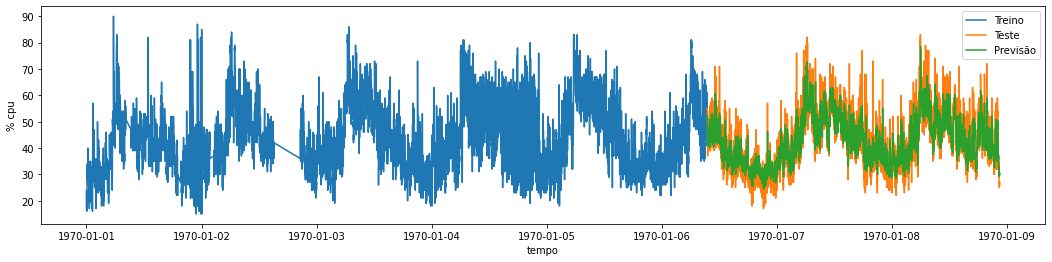

In [6]:
# Gráfico da previsão x teste
result = workload[-test_len+90:-90].copy()
result['predict'] = predict[90:]

plt.figure(figsize=(18,4))
plt.plot(train_set, label = 'Treino')
plt.plot(result['cpu'], label = 'Teste')
plt.plot(result['predict'], label = 'Previsão')
plt.xlabel('tempo')
plt.ylabel('% cpu')
plt.legend()
plt.show()

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [7]:
mse(result['cpu'], result['predict'])

36.100911217695085